# Keras network

In [12]:
import os
import numpy as np
import keras
from keras import layers
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow import data as tf_data
import matplotlib.pyplot as plt
from tensorflow import one_hot
from keras.models import load_model

In [21]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "data",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    color_mode="grayscale"
)



Found 15000 files belonging to 3 classes.
Using 12000 files for training.
Using 3000 files for validation.


In [3]:
def preprocess(image, label):
    # Convert integer label to one-hot encoding
    label =one_hot(label, depth=3)
    return image, label


train_ds = train_ds.map(preprocess)
val_ds = val_ds.map(preprocess)

2024-11-18 09:52:07.526838: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


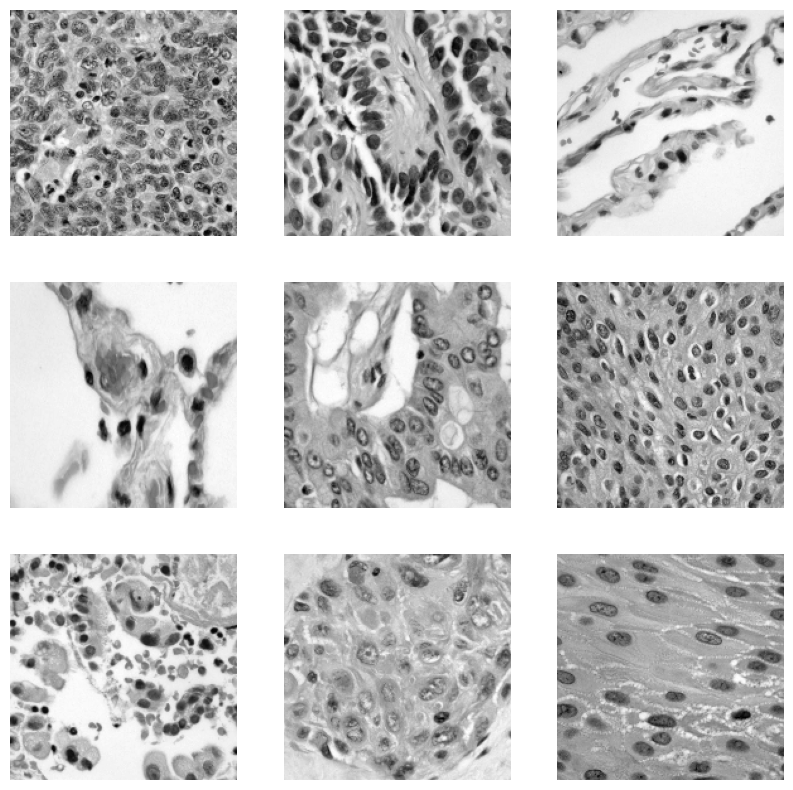

In [5]:

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]),cmap='gray')
        plt.axis("off")

In [26]:
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

In [27]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(3, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size+(1,), num_classes=3)
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [ ]:
epochs = 1

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.CategoricalAccuracy(name="acc")],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1169s 12s/step - acc: 0.8885 - loss: 0.2838 - val_acc: 0.3223 - val_loss: 1.1613
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 3189s 34s/step - acc: 0.9396 - loss: 0.1469 - val_acc: 0.3223 - val_loss: 1.5852
Epoch 3/10
 7/94 ━━━━━━━━━━━━━━━━━━━━ 18:01 12s/step - acc: 0.9683 - loss: 0.0887

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import confusion_matrix
model = load_model('save_at_2.keras')
# Predict

y_prediction = model.predict(val_ds)

# Extract true labels
y_true = np.concatenate([y for x, y in val_ds], axis=0)

# Convert y_true to class indices
y_true_indices = np.argmax(y_true, axis=1)

# Convert model predictions to class indices
y_pred = np.argmax(y_prediction, axis=1)

# Compute confusion matrix
result = confusion_matrix(y_true_indices, y_pred)
print(result)

24/24 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step
[[0.         0.         0.34      ]
 [0.         0.         0.33766667]
 [0.         0.         0.32233333]]


In [15]:
result = confusion_matrix(y_true_indices, y_pred)
print(result)

[[   0    0 1020]
 [   0    0 1013]
 [   0    0  967]]


np.float64(2.0)